이 튜토리얼은 두 가지 방법으로 이미지 데이터세트를 로드하고 전처리하는 방법을 보여줍니다. 먼저, 고급 Keras 전처리 [유틸리티](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) 및 [레이어](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing)를 사용합니다. 다음으로 [tf.data](https://www.tensorflow.org/guide/data)를 사용하여 처음부터 자체 입력 파이프라인을 작성합니다.

## 설정

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.4.1


### 꽃 데이터세트 다운로드하기

이 튜토리얼에서는 수천 장의 꽃 사진 데이터세트를 사용합니다. 꽃 데이터세트에는 클래스당 하나씩 5개의 하위 디렉토리가 있습니다.

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

참고: 모든 이미지에는 CC-BY 라이선스가 있으며 크리에이터는 LICENSE.txt 파일에 나열됩니다.

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 1s 0us/step


In [5]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

다운로드한 후 (218MB), 이제 꽃 사진의 사본을 사용할 수 있습니다. 총 3670개의 이미지가 있습니다.

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


각 디렉토리에는 해당 유형의 꽃 이미지가 포함되어 있습니다. 다음은 장미입니다.

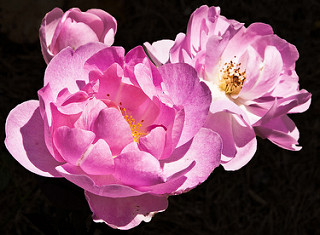

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

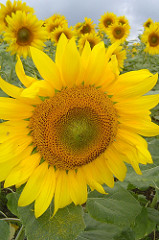

In [8]:
sunflowers = list(data_dir.glob('sunflowers/*'))
PIL.Image.open(str(sunflowers[0]))

## keras.preprocessing을 사용하여 로드하기

[image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)를 사용하여 이들 이미지를 디스크에 로드해 보겠습니다.

### 데이터세트 만들기

로더를 위해 일부 매개변수를 정의합니다.

In [9]:
batch_size = 32
img_height = 180
img_width = 180

모델을 개발할 때 검증 분할을 사용하는 것이 좋습니다. 훈련에 이미지의 80%를 사용하고 검증에 20%를 사용합니다.

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


이러한 데이터세트의 `class_names` 속성에서 클래스 이름을 찾을 수 있습니다.

In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### 데이터 시각화하기

훈련 데이터세트의 처음 9개 이미지는 다음과 같습니다.

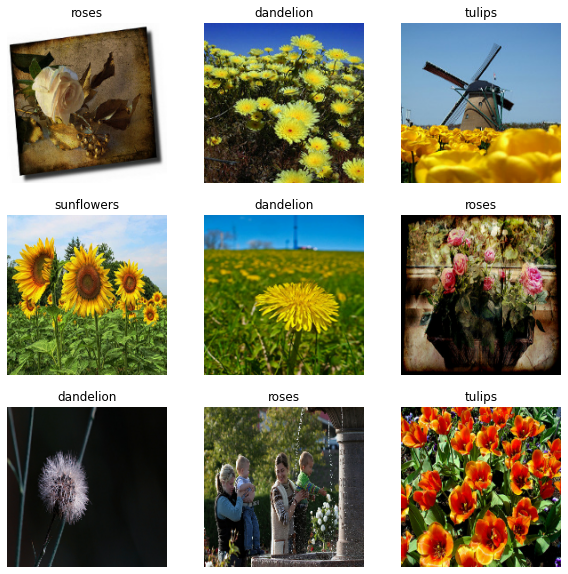

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

이러한 데이터세트를 사용하는 모델을 `model.fit`(이 튜토리얼의 뒷부분에 표시)에 전달하여 모델을 훈련할 수 있습니다. 원하는 경우, 데이터세트를 수동으로 반복하고 이미지 배치를 검색할 수도 있습니다.

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`image_batch`는 형상 `(32, 180, 180, 3)`의 텐서입니다. 이것은 형상 `180x180x3`의 32개 이미지 배치입니다(마지막 치수는 색상 채널 RGB를 나타냄). `label_batch`는 형상 `(32,)`의 텐서이며 32개 이미지에 해당하는 레이블입니다.


참고: 이들 텐서 중 하나에서 `.numpy()`를 호출하여 `numpy.ndarray`로 변환할 수 있습니다.

### 데이터 표준화하기


RGB 채널 값은 `[0, 255]` 범위에 있습니다. 신경망에는 이상적이지 않습니다. 일반적으로 입력 값을 작게 만들어야 합니다. 여기서는 Rescaling 레이어를 사용하여 값이 `[0, 1]`에 있도록 표준화합니다.

In [15]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

이 레이어를 사용하는 방법에는 두 가지가 있습니다. map을 호출하여 데이터세트에 레이어를 적용할 수 있습니다.

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.96902645


또는 모델 정의 내에 레이어를 포함하여 배포를 단순화할 수 있습니다. 여기서는 두 번째 접근 방식을 사용할 것입니다.

참고: 픽셀 값을 `[-1,1]`으로 조정하려면 대신 `Rescaling(1./127.5, offset=-1)`를 작성할 수 있습니다.

참고: 이전에 `image_dataset_from_directory`의 `image_size` 인수를 사용하여 이미지 크기를 조정했습니다. 모델에 크기 조정 논리를 포함하려면 [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) 레이어를 대신 사용할 수 있습니다.


### 성능을 위한 데이터세트 구성하기

버퍼링된 프리페치를 사용하여 I/O가 차단되지 않고 디스크에서 데이터를 생성할 수 있도록 합니다. 데이터를 로드할 때 사용해야 하는 두 가지 중요한 메서드입니다.

`.cache()`는 첫 번째 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.

`.prefetch()`는 훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다.

관심 있는 독자는 [데이터 성능 가이드](https://www.tensorflow.org/guide/data_performance#prefetching)에서 두 가지 메서드와 디스크에 데이터를 캐시하는 방법에 대해 자세히 알아볼 수 있습니다.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 모델 훈련하기

완전성을 위해 준비한 데이터세트를 사용하여 간단한 모델을 훈련하는 방법을 보여줍니다. 이 모델은 어떤 식으로든 조정되지 않았습니다. 목표는 방금 만든 데이터세트를 사용하여 역학을 보여주는 것입니다. 이미지 분류에 대한 자세한 내용은 이 [튜토리얼](https://www.tensorflow.org/tutorials/images/classification)을 참조하세요.

In [18]:
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

참고: 몇 가지 epoch에 대해서만 훈련하므로 이 튜토리얼은 빠르게 진행됩니다. 

In [20]:
model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 15s 84ms/step - loss: 1.4555 - accuracy: 0.3517 - val_loss: 1.0909 - val_accuracy: 0.5681
Epoch 2/3
92/92 [==============================] - 3s 32ms/step - loss: 1.0726 - accuracy: 0.5391 - val_loss: 1.0843 - val_accuracy: 0.5654
Epoch 3/3
92/92 [==============================] - 3s 32ms/step - loss: 0.9694 - accuracy: 0.6134 - val_loss: 0.9456 - val_accuracy: 0.6335


참고: `model.fit`을 사용하는 대신 사용자 정의 훈련 루프를 작성할 수도 있습니다. 자세한 내용은 이 [튜토리얼](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)을 참조하세요.

검증 정확성이 훈련 정확성에 비해 낮으므로 모델이 과대적합되었음을 알 수 있습니다. 이 [튜토리얼](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)에서 과대적합 및 축소 방법에 대해 자세히 알아볼 수 있습니다.

## 미세 제어를 위해 tf.data 사용하기

위의 keras.preprocessing 유틸리티는 이미지의 디렉토리에서 `tf.data.Dataset`을 작성하는 편리한 방법입니다. 보다 세밀한 제어를 위해 `tf.data`을 사용하여 자체 입력 파이프라인을 작성할수 있습니다. 이 섹션에서는 이전에 다운로드한 zip 파일 경로부터 시작하여 이를 수행하는 방법을 보여줍니다.

In [21]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [22]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/daisy/2607132536_d95198e619_n.jpg'
b'/root/.keras/datasets/flower_photos/daisy/18400014056_2e4c601ed5.jpg'
b'/root/.keras/datasets/flower_photos/daisy/4544110929_a7de65d65f_n.jpg'
b'/root/.keras/datasets/flower_photos/roses/3315973481_850d2253e9_n.jpg'
b'/root/.keras/datasets/flower_photos/daisy/5874818796_3efbb8769d.jpg'


파일의 트리 구조를 사용하여 `class_names` 목록을 컴파일할 수 있습니다.

In [23]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


데이터세트를 훈련 및 검증으로 분할합니다.

In [24]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

다음과 같이 각 데이터세트의 길이를 볼 수 있습니다.

In [25]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


파일 경로를 `(img, label)` 쌍으로 변환하는 간단한 함수를 작성합니다.

In [26]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [27]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [28]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

`Dataset.map`을 사용하여 `image, label` 쌍의 데이터세트를 작성합니다.

In [29]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [30]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


### 성능을 위한 데이터세트 구성하기

이 데이터세트로 모델을 훈련하려면 데이터에 대해 다음이 필요합니다.

- 잘 섞는다.
- 배치 처리한다.
- 가능한 빨리 배치를 사용할 수 있어야 한다.

이러한 기능은 `tf.data` API를 사용하여 추가할 수 있습니다. 자세한 내용은 [입력 파이프라인 성능](../../guide/performance/datasets) 가이드를 참조하세요.

In [31]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### 데이터 시각화하기

이 데이터세트를 이전에 작성한 데이터세트와 유사하게 시각화할 수 있습니다.

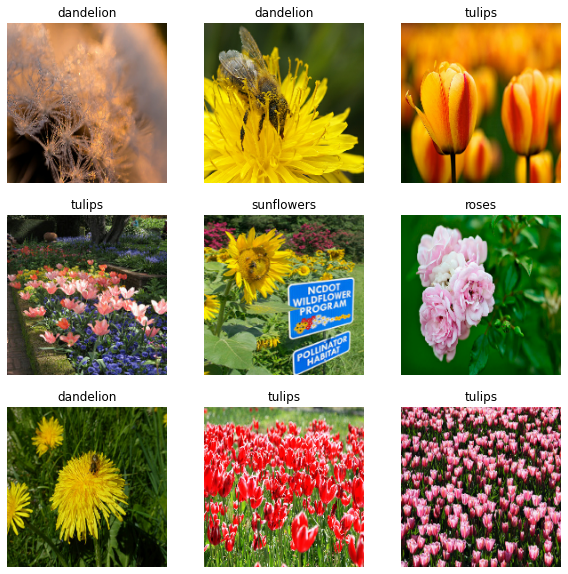

In [32]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### 모델 계속 훈련하기

위의 `keras.preprocessing`에 의해 작성된 것과 유사한 `tf.data.Dataset`를 수동으로 빌드했습니다. 모델 훈련을 계속할 수 있습니다. 이전과 마찬가지로 실행 시간을 짧게 유지하기 위해 몇 가지 epoch 동안 훈련합니다.

In [33]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 9s 78ms/step - loss: 0.8007 - accuracy: 0.6897 - val_loss: 0.8712 - val_accuracy: 0.6703
Epoch 2/3
92/92 [==============================] - 3s 36ms/step - loss: 0.6283 - accuracy: 0.7643 - val_loss: 0.7367 - val_accuracy: 0.6975
Epoch 3/3
92/92 [==============================] - 3s 36ms/step - loss: 0.4321 - accuracy: 0.8525 - val_loss: 0.8388 - val_accuracy: 0.7084


## TensorFlow 데이터세트 사용하기

이 튜토리얼에서는 지금까지 디스크에서 데이터를 로드하는 데 중점을 두었습니다. [TensorFlow 데이터세트](https://www.tensorflow.org/datasets)에서 다운로드하기 쉬운 대규모 데이터세트 [카탈로그](https://www.tensorflow.org/datasets)를 탐색하여 사용할 데이터세트를 찾을 수도 있습니다. 이전에 Flowers 데이터세트를 디스크에서 로드했으므로 TensorFlow 데이터세트로 가져오는 방법을 살펴보겠습니다. 

TensorFlow 데이터세트를 사용하여 꽃 [데이터세트](https://www.tensorflow.org/datasets/catalog/tf_flowers)를 다운로드합니다.

In [34]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


꽃 데이터세트에는 5개의 클래스가 있습니다.

In [35]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


데이터세트에서 이미지를 검색합니다.

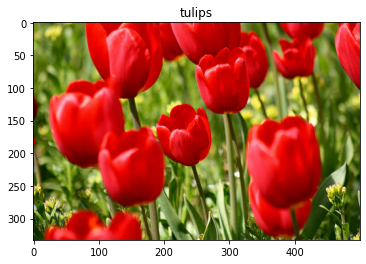

In [36]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

이전과 마찬가지로, 성능을 위해 각 데이터세트를 일괄 처리, 셔플 및 구성해야 합니다.

In [37]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

[데이터 강화](https://www.tensorflow.org/tutorials/images/data_augmentation) 가이드를 방문하여 꽃 데이터세트 및 TensorFlow 데이터세트를 처리하는 전체 예제를 찾을 수 있습니다.

## 다음 단계

이 튜토리얼에서는 디스크에서 이미지를 로드하는 두 가지 방법을 보여주었습니다. 먼저 Keras 전처리 레이어 및 유틸리티를 사용하여 이미지 데이터세트를 로드하고 전처리하는 방법을 배웠습니다. 다음으로, tf.data를 사용하여 처음부터 입력 파이프라인을 작성하는 방법을 배웠습니다. 다음 단계로 이 [튜토리얼](https://www.tensorflow.org/tutorials/images/data_augmentation)을 방문하여 데이터 기능 보강을 추가하는 방법을 학습할 수 있습니다. tf.data에 대한 자세한 내용은 이 [가이드](https://www.tensorflow.org/guide/data)를 참조하세요.